# 뉴스 요약봇 만들기

### 모듈 불러오기

In [2]:
# 뉴스 봇 만들기 
# 불용어 제거
#NLTK는 Natural Language Toolkit의 축약어로 영어 기호, 통계, 자연어 처리를 위한 라이브러리

import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords


from bs4 import BeautifulSoup 

from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences

import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')


[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Review 데이터 불러오기
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
#data = pd.read_csv(os.getenv("HOME")+"/aiffel/news_summarization/data/Reviews.csv", nrows=100)
print('전체 샘플수 :', (len(data)))
data.head(2)

전체 샘플수 : 98401


,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...


In [4]:
data.sample(10)

,headlines,text
37070,US' separation of migrant kids may amount to t...,The US government's policy of separating migra...
78274,Digital currencies are an unfounded fad: Billi...,Investment firm Oaktree Capital's Co-chairman ...
19628,You die of shame: Coach shouted at Tajinderpal...,Shot-putter Tajinderpal Singh's coach MS Dhill...
38460,Vast improvement in countering J&K insurgency:...,There has been a vast improvement in India's w...
7437,Alok untraceable after rape FIR filed against ...,Actor Alok Nath has gone missing after a rape ...
64030,BSE asks brokers for update on clients' Aadhaa...,BSE asked its brokers to submit details about ...
87686,The term 'women-oriented cinema' is sexist: Ad...,"Talking about 'women-oriented cinema', actress..."
40293,Russian cosmonauts play football with 2018 WC ...,Russian cosmonauts Oleg Artemyev and Anton Shk...
88599,"IBM denies reports of firing 5,000 employees i...",IBM on Wednesday said media reports about the ...
56073,Hyderabad firm booked for cheating SBI of Ã¢Â...,The CBI has booked a case against Hyderabad-ba...


In [7]:
# 우리는 전체 데이터 중 Summary와 Text 열만 사용
data = data.rename(columns={"text":"Text"})
data = data[['Text','headlines']]
data.head()

,Text,headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."


### 데이터 전처리 - 중복 제거

In [8]:
# 데이터 전처리 하기
# 데이터 null 값 존재하는 샘플 제거
print('Text 유일한 샘플의 수 :', data['Text'].nunique())
print('headlines 유일한 샘플의 수 :', data['headlines'].nunique())


# headlines 같은 경우에는 간단한 요약이 많아서 겹칠 수 있다.
# 하지만 text 같은 경우에는 중복된 경우 제거를 해야한다.
# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data = data.drop_duplicates(subset = ['Text'])
print('전체 샘플수 :', (len(data)))

Text 유일한 샘플의 수 : 98360
headlines 유일한 샘플의 수 : 98280
전체 샘플수 : 98360


### 데이터 전처리 - null 제거

In [9]:
# 중복되는 값은 삭제해 주었지만 여전히 Null 값이 남아 있기 때문에 처리해준다,
print(data.isnull().sum())

# null 있는 행 제거
data = data.dropna(axis = 0)
print("전체 샘플 수: ",len(data))

Text         0
headlines    0
dtype: int64
전체 샘플 수:  98360


### 데이터 전처리 - 불용어 제거

In [10]:
# 텍스트 정규화와 불용어 제거
# 의미가 같은 표현은 연상량을 줄이기 위해 미리 같은 표현으로 통일 시켜준다

# text dictionary 구성
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [11]:
# 자연어를 처리할 때 실질적으로 별 도움이 되지 않는 단어들 제거
# NLTK에서 제공하는 불용어 리스트를 참조해서 불용어 제거

# NLTK에서 미리 정의해서 제공하고 있는 불용어가 179개이다
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

### 데이터 전처리 함수 -  Sentence

In [12]:
# 문자는 소문자로 통일, html 태그 제거, 각종 특수문자 제거
# 상대적으로 길이가 짧은 headlines 전처리할 때는 호출하지 않는다.
# 그 이유는 요약 결과문이 자연스럽게 처리되기 위해서 이다.


# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [13]:
# 제대로 작동하는지 test
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'


print("text: ", preprocess_sentence(temp_text))
# summary는 불용어를 제거하지 않는다고 했기 때문에 인자에 False를 넣어준다,
print("headlines:", preprocess_sentence(temp_summary, False)) 

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


### 데이터 전처리 함수 - Sentences

In [14]:
# 전체 문장 데이터 전처리 함수
def preprocess_sentences(data, col,remove_stopwords=True):
    clean_text = []
    
    # for문으로 모든 문장에 전처리 함수 적용
    for text in data[col]:
        clean_text.append(preprocess_sentence(text,remove_stopwords))
    
    # 전처리 후 출력
    print(f"{col} 전처리 후 결과: ", clean_text[:5])
    return clean_text

clean_text =  preprocess_sentences(data, 'Text',remove_stopwords=True)
print("")
clean_summary =  preprocess_sentences(data, 'headlines',remove_stopwords=False)


Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [101]:
# 정제 과정에서 전처리가 된 후에는 남는 단어가 없어서 빈 샘플이 생성될 수 잇다.
data['Text']= clean_text
data['headlines'] = clean_summary

# 빈 값을 Null 값으로 변환
data = data.replace('',np.nan)
data

ValueError: Length of values (98360) does not match length of index (96871)

In [16]:
# 결측치로 잘 대체되었는지 확인
data.isnull().sum()

Text         0
headlines    0
dtype: int64

In [17]:
# nan값이 아닌 샘플들만 가져오기
data = data.dropna(axis=0)
print(len(data))

98360


### 문장 정보 함수

In [18]:
def sentence_info(data,col):
    # 각 행의 한 문장씩 split하여 길이 정보를 저장함
    text_len = [len(s.split()) for s in data[col]]

    # 저장한 길이 정보를 토대로 최대, 최소 ,평균을 구함
    print(f'{col}의 최소 길이 : {np.min(text_len)}')
    print(f'{col}의 최대 길이 : {np.max(text_len)}')
    print(f'{col}의 평균 길이 : {np.mean(text_len)}')
    
    return text_len

Text의 최소 길이 : 1
Text의 최대 길이 : 60
Text의 평균 길이 : 35.09968483123221
headlines의 최소 길이 : 1
headlines의 최대 길이 : 16
headlines의 평균 길이 : 9.299532330215534


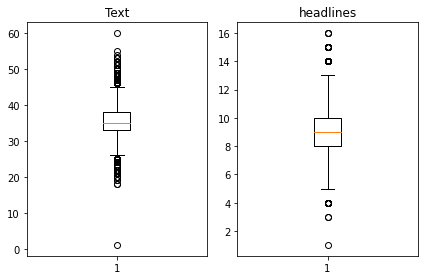

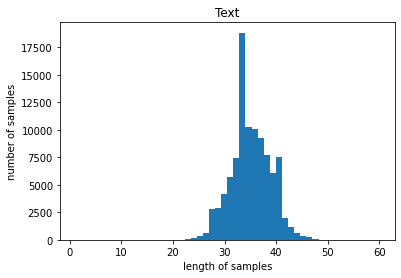

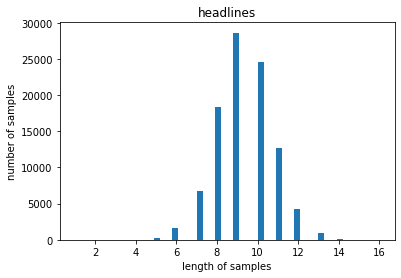

In [19]:
# 샘플의 최대 길이 정하기
# 문장의 사작과 끝 표시해주기

# 길이 분포 출력
import matplotlib.pyplot as plt

# 문장의 길이정보를 토대로 최대 최소 평균
text_len = sentence_info(data,'Text')
summary_len = sentence_info(data,'headlines')


# text 정보 시각화
plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('Text')
plt.subplot(1,2,2)
plt.boxplot(summary_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('Text')
plt.hist(text_len, bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(summary_len, bins = 50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [107]:
# 최대 길이에 대한 차이 존재
# text의 경우 대체적으로 평균 길이는 38, 대체적으로 100내외의 길이
# headlines 경우 최대 길이가 28 , 평균 길이가 4, 대체적으로 10이하의 길이


# 임의의 길이
text_max_len = 40
summary_max_len = 10

### 길이를 토대로 샘플의 해당 비율 출력 함수

In [108]:
# 우리가 선택한 임의의 길이를 가지고 데이터를 살펴보면 얼마나 데이터가 해당될까
def below_threshold_len(max_len, nested_list):
  cnt = 0

  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))


below_threshold_len(text_max_len, data['Text'])
below_threshold_len(summary_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 10 이하인 샘플의 비율: 0.8254191033138402


In [109]:
# text는 23%의 샘플이 정보가 손실되는 것이다
# 따라서 max len보다 긴 샘플들은 제거

data = data[data['Text'].apply(lambda x : len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x : len(x.split()) <= summary_max_len)]
len(data)

74102

In [110]:
# 시작과 종료 토큰 추가하기
# 디코더의 입ㄺ과 레이블에 시작토큰과 종료 토큰을 추가해줘야 한다

# 시작토큰 sostoken
# 종료 토큰 eostoken
# decoder의 입력, 시작 토큰이 맨 앞에 있는 문장 이름 decoder input
# decoder의 입력, 종료 토큰이 맨 뒤에 있는 문장 이름 decoder target
# 두 문장 모두 headlines 열로 만든다

data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,Text,headlines,decoder_input,decoder_target
2,new zealand defeated india wickets fourth odi ...,new zealand end rohit sharma led india match w...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan customers enjo...,aegon life iterm insurance plan helps customer...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,pakistani singer rahat fateh ali khan denied r...,rahat fateh ali khan denies getting notice for...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
9,congress candidate shafia zubair ramgarh assem...,cong wins ramgarh bypoll in rajasthan takes to...,sostoken cong wins ramgarh bypoll in rajasthan...,cong wins ramgarh bypoll in rajasthan takes to...
10,two minor cousins uttar pradesh gorakhpur alle...,up cousins fed human excreta for friendship wi...,sostoken up cousins fed human excreta for frie...,up cousins fed human excreta for friendship wi...


In [159]:
# text sentence은 encoder의 input 데이터
encoder_input = np.array(data['Text']) # 인코더의 입력

# token이 붙은 decoder의 input과 target 데이터
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

### Shuffle train test 데이터 생성 함수

In [160]:
def train_test_data_shuffle(encoder_input_len,encoder_input,decoder_input,decoder_target):
    # encoder의 input값 만큼 인덱스를 생성한다
    indices = np.arange(encoder_input_len)
    # indices를 섞는다
    np.random.shuffle(indices)


    # 원본 데이터 세트를 섞은 index 값이 담겨있는 list로 섞어준다
    encoder_input = encoder_input[indices]
    decoder_input = decoder_input[indices]
    decoder_target = decoder_target[indices]

    # 데이터를 8 : 2 비율로 분리
    n_of_val = int(len(encoder_input)*0.2)

    # 테스트 데이터 범위를 제외하고 train 데이터 만들기
    encoder_input_train = encoder_input[:-n_of_val]
    decoder_input_train = decoder_input[:-n_of_val]
    decoder_target_train = decoder_target[:-n_of_val]

    encoder_input_test = encoder_input[-n_of_val:]
    decoder_input_test = decoder_input[-n_of_val:]
    decoder_target_test = decoder_target[-n_of_val:]

    print('훈련 데이터의 개수 :', len(encoder_input_train))
    print('훈련 레이블의 개수 :', len(decoder_input_train))
    print('테스트 데이터의 개수 :', len(encoder_input_test))
    print('테스트 레이블의 개수 :', len(decoder_input_test))
      
    return encoder_input_train, decoder_input_train,decoder_target_train,encoder_input_test,decoder_input_test,decoder_target_test


encoder_input_train,\
decoder_input_train,\
decoder_target_train,\
encoder_input_test,\
decoder_input_test,\
decoder_target_test=train_test_data_shuffle(encoder_input.shape[0],
                                            encoder_input,
                                            decoder_input,
                                            decoder_target)

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14820
테스트 레이블의 개수 : 14820


### 단어 집합의 정보 출력 함수

In [161]:
# 정수 인코딩하기
# 텍스트 데이터를 숫자로 처리할 수 있도록 훈련 데이터와테스트 데이터의단어 정수로 변경
# 단어 집합 만들기

def word_set_ratio(threshold, data):

    # Keras  토크나이저
    tokenizer = Tokenizer() 
    # 입력된 데이터로부터 단어 집합 생성
    tokenizer.fit_on_texts(data) 
    # 단어에 고유한 정수 부여
    # 단어 집합이 생성 src_tokenizer.word_index에 저장
    # 빈도수가 낮은 단어들은 훈련 데이터에서 제외


    # 등장 빈도수 7번
    threshold = threshold
    total_cnt = len(tokenizer.word_index) # 단어의 수


    # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    rare_cnt = 0 
    # 훈련 데이터의 전체 단어 빈도수 총 합
    total_freq = 0 
    # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합
    rare_freq = 0 


    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :', total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)
    print("==============================================================================")


In [162]:
# 단어 집합의 정보
print("encoder input train")
word_set_ratio(5, encoder_input_train)
print("decoder input train")
word_set_ratio(4, decoder_input_train)

encoder input train
단어 집합(vocabulary)의 크기 : 61707
등장 빈도가 4번 이하인 희귀 단어의 수: 38619
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 23088
단어 집합에서 희귀 단어의 비율: 62.584471777918225
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.1988030040033215
decoder input train
단어 집합(vocabulary)의 크기 : 27288
등장 빈도가 3번 이하인 희귀 단어의 수: 15763
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 11525
단어 집합에서 희귀 단어의 비율: 57.765318088537086
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.085351728398239


In [163]:
def size_limit_text2seq(vocab_limit, input_train, input_test, target_train, target_test):
    src_vocab = vocab_limit

    # Check if target_train and target_test are empty arrays
    if not target_train.any() and not target_test.any():
        src_tokenizer = Tokenizer(num_words=src_vocab) 
        src_tokenizer.fit_on_texts(input_train)
        # encoder 텍스트 시퀀스를 정수 시퀀스로 변환
        encoder_input_train = src_tokenizer.texts_to_sequences(input_train) 
        encoder_input_test = src_tokenizer.texts_to_sequences(input_test)
        
        # Print a few samples to check progress
        # print(encoder_input_train[:3])

        return src_tokenizer, encoder_input_train, encoder_input_test
    else:
        tar_vocab = vocab_limit  # Assuming tar_vocab should also be set to vocab_limit
        tar_tokenizer = Tokenizer(num_words=tar_vocab)
        tar_tokenizer.fit_on_texts(input_train)
        tar_tokenizer.fit_on_texts(target_train)
        # 텍스트 시퀀스를 정수 시퀀스로 변환, 반환값 list
        decoder_input_train = tar_tokenizer.texts_to_sequences(input_train) 
        decoder_target_train = tar_tokenizer.texts_to_sequences(target_train)
        decoder_input_test = tar_tokenizer.texts_to_sequences(input_test)
        decoder_target_test = tar_tokenizer.texts_to_sequences(target_test)

        return tar_tokenizer, decoder_input_train, decoder_target_train, decoder_input_test, decoder_target_test

# Example usage
src_tokenizer, encoder_input_train, encoder_input_test = size_limit_text2seq(23000, encoder_input_train, encoder_input_test, np.array([]), np.array([]))
tar_tokenizer,decoder_input_train, decoder_target_train, decoder_input_test, decoder_target_test = size_limit_text2seq(12000, decoder_input_train, decoder_input_test, decoder_target_train,decoder_target_test)


In [164]:
# 이전과 동일하게 전처리를 해주고 나서 데이터를 삭제하고 나면
# 빈도수가 낮은 단어가 많이 포함되었던 샘플들은 빈 샘플이 될 가능성이 있다.

# 또 추가한 토큰도 모든 sentence에 있기 때문에 빈도수 높은 단어에 해당한다
# 따라서 집합 제한에서도 삭제되지 않는다.
# 빈 샘플의 요약문은 길이가 1개로 나올 것이다.

# drop할 index를 list에 저장
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))


def drop_sentence(index_list, data):
    temp = [sentence 
          for index, sentence in enumerate(data) 
          if index not in index_list]
    return temp

encoder_input_train = drop_sentence(drop_train,encoder_input_train)
decoder_input_train = drop_sentence(drop_train,decoder_input_train)
decoder_target_train = drop_sentence(drop_train,decoder_target_train)

encoder_input_test = drop_sentence(drop_test,encoder_input_test)
decoder_input_test = drop_sentence(drop_test,decoder_input_test)
decoder_target_test = drop_sentence(drop_test,decoder_target_test)


print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 1
훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14819
테스트 레이블의 개수 : 14819


In [165]:
# 패딩하기
# 패딩을 하는 이유는 서로 다른 길이의 샘플들을 병렬 처리하기 위해서 이다.


# post에 padding
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=summary_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=summary_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=summary_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=summary_max_len, padding='post')

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 59282
훈련 레이블의 개수 : 59282
테스트 데이터의 개수 : 14819
테스트 레이블의 개수 : 14819


### 모델 설계하기

In [280]:
# LSTM으로 인코더 디코더 설계하기

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 300
# hidden state는 얼마만큼의 수용력을 가질지 정하는 파라미터
hidden_size = 128

# 인코더
encoder_inputs = Input(shape=(text_max_len,))
src_vocab = 23000
# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.5)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.5)
encoder_output3, state_h3, state_c3 = encoder_lstm2(encoder_output2)

In [281]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))
tar_vocab =12000
# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)


# initial state의 인자값으로 hidden state와 cell state 값을 넣어주어야 한다
# 아마도 인코더에서 생성한 값들을 디코더로 넘겨주는 과정인 것 같다
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h3, state_c3])

In [282]:
# 디코더의 출력층 
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_31"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 40, 300)      6900000     input_44[0][0]                   
__________________________________________________________________________________________________
lstm_66 (LSTM)                  [(None, 40, 128), (N 219648      embedding_32[0][0]               
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

### Attention 메커니즘을 도입한 모델

In [283]:
# 디코더 출력층에서는 다중 클래스 분류 문제를 풀어야 한다.
# 따라서 Dense의 인자로 tar vocab을 주고 활성화함수를 소프트맥스로 사용한다

# 어텐션 메커니즘의 도입 - Bahdanau 스타일의 어텐션
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')


# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
# 디코덕가 각 인코더의 hidden state에 얼마나 주의를 기울여야 하는지를 가중치로 나타낸다
# 전달하는 값은 모든 타임 스텝에 대한 hidden state
attn_out = attn_layer([decoder_outputs, encoder_output3])


# 어텐션의 결과와 디코더의 hidden state들을 연결
# 디코더의 현 스텝에서 hidden state에 대한 가중합을 계산하는데,
# 이때 인코더의 hidden state를 기준으로 가중치를 계산한다
# 첫번째 입력 디코더 현재 타임 스텝에 대한 hidden state
# 두번 째 입력으로 전달 인코더의 모든 타임 스텝에 대한 hidden state
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])


# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)


# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_32"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_44 (InputLayer)           [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 40, 300)      6900000     input_44[0][0]                   
__________________________________________________________________________________________________
lstm_66 (LSTM)                  [(None, 40, 128), (N 219648      embedding_32[0][0]               
__________________________________________________________________________________________________
input_45 (InputLayer)           [(None, None)]       0                                            
___________________________________________________________________________________________

In [284]:
decoder_target_train

array([[3563, 1284,  172, ...,   81,    2,    0],
       [  34,   33,   26, ...,    2,    0,    0],
       [3353,   76,    4, ..., 1629,    2,    0],
       ...,
       [1236,    8,    5, ...,   14, 4571,    2],
       [  65,   86, 3317, ...,   17, 2860,    2],
       [  11, 2077,   53, ...,  893,    2,    0]], dtype=int32)

In [285]:
# 모델 컴파일
model.compile(optimizer='Adam', 
              loss='sparse_categorical_crossentropy')

es = EarlyStopping(monitor='val_loss',
                   patience=9, 
                   verbose=1)


In [286]:
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=100)

Epoch 1/100
232/232 [==============================] - 18s 57ms/step - loss: 6.7715 - val_loss: 6.2299
Epoch 2/100
232/232 [==============================] - 12s 53ms/step - loss: 6.2151 - val_loss: 6.0387
Epoch 3/100
232/232 [==============================] - 12s 54ms/step - loss: 5.9411 - val_loss: 5.7080
Epoch 4/100
232/232 [==============================] - 13s 54ms/step - loss: 5.5104 - val_loss: 5.3242
Epoch 5/100
232/232 [==============================] - 13s 55ms/step - loss: 5.1368 - val_loss: 5.0825
Epoch 6/100
232/232 [==============================] - 13s 56ms/step - loss: 4.8444 - val_loss: 4.8995
Epoch 7/100
232/232 [==============================] - 13s 56ms/step - loss: 4.5968 - val_loss: 4.7621
Epoch 8/100
232/232 [==============================] - 13s 55ms/step - loss: 4.3812 - val_loss: 4.6502
Epoch 9/100
232/232 [==============================] - 13s 55ms/step - loss: 4.1897 - val_loss: 4.5655
Epoch 10/100
232/232 [==============================] - 13s 55ms/step - l

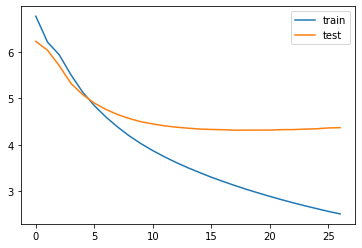

In [287]:
# history loss 값 시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 텍스트 데이터를 실제 데이터로 복원하기

In [194]:
# 원문 단어 집합에서 정수 -> 단어를 얻음
src_index_to_word = src_tokenizer.index_word 

# 요약 단어 집합에서 단어 -> 정수를 얻음
tar_word_to_index = tar_tokenizer.word_index


# 요약 단어 집합에서 정수 -> 단어를 얻음
tar_index_to_word = tar_tokenizer.index_word 




In [195]:
# 정답이 없는 요약 문제를 생성하기 위해서는 실제 동작할 때의 방식이 다르므로
# 인퍼런스 모델 설계를 별도로 해주어야 한다

# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_output3, state_h3, state_c3])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])


In [196]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])


In [197]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

In [198]:
# 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp


# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0) and (i !=1 ) and (i !=2) :
            temp = temp + src_index_to_word[i]+' '
    return temp



In [199]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : federal judge dismissed defamation lawsuit filed pornstar stormy daniels donald trump us president called reacting trump remark daniels called tiny lawyer tweeted disgusting embarrassment united states daniels claims sexual relationship trump 
실제 요약 : last data pink overbooked gurdwara 
예측 요약 :  trump lawyer files lawsuit against trump over sexual harassment


원문 : letter paying tribute late actress sridevi union minister smriti irani wrote farewell star whose last words ring true forever else would irani revealed sridevi said thanked sridevi attending international film festival india goa november 
실제 요약 : cctv medical aimed long dogs year second added young happy 
예측 요약 :  anupam kher to make sridevi in tubelight


원문 : indian batsman shikhar dhawan revealed celebration taking catch field inspired sport kabaddi dhawan said australia took shane watson catch since likes watch kabaddi adopted celebration kabaddi sport dhawan said 
실제 요약 : champion beginning polls old cabin tennis 


예측 요약 :  rahul gandhi is like national illness shah


원문 : former finance minister chidambaram monday said biggest issue lok sabha elections unemployment adding government incompetent know create jobs chidambaram suggested least five teachers recruited one teacher schools millions jobs created 
실제 요약 : associates year new highways sharing added staged received recovered 
예측 요약 :  will not have integrity of polls chidambaram


원문 : rjd leader bhai monday refused remove red beacon atop car said order bihar government cabinet decided bihar follow decision delhi cabinet government pass order follow rule said 
실제 요약 : article per baby year german awarded talwar film lakh home 
예측 요약 :  lalu yadav sits on hunger strike in delhi nagar


원문 : us food drug administration approved new gene therapy treat children adult patients inherited form vision loss may result blindness whose safety established patient trial first directly administered gene therapy targets disease caused specific gene 
실제 요약

예측 요약 :  french town passes away at


원문 : maruti suzuki became first indian automaker cross trillion market capitalisation shares hit mark intraday trade wednesday also became country sixth company cross milestone notably maruti market cap around higher parent japan suzuki motor corporation 
실제 요약 : pooja man reports constellation year follow wednesday like council pollution 
예측 요약 :  maruti suzuki crosses trillion market for first time


원문 : government clarified whatsapp cannot launch payments services whatsapp pay india without office team country government also planning approach rbi make sure company violate rules however whatsapp said setting india team priority currently looking leadership positions 
실제 요약 : shah city director third added government children coach court 
예측 요약 :  whatsapp not provided payments on whatsapp payments govt


원문 : day lok sabha rajya sabha wednesday passed constitution bill introduce reservation economically weaker sections among general category jo

### 추출적 요약해보기

In [231]:
import requests
from summa.summarizer import summarize

In [244]:
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')
text = requests.get('http://rare-technologies.com/the_matrix_synopsis.txt').text

In [252]:
data['text'].values[0]
     

"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers."

In [254]:
for i in range(0, 50):
    input_text =  data['text'].values[i]
    print("원문 :", input_text)
    
    print("예측 요약",summarize(input_text, ratio=0.5))
    print("\n")

원문 : Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program and upGrad's 360-degree career support helped him transition to a Data Scientist at Tech Mahindra with 90% salary hike. upGrad's Online Power Learning has powered 3 lakh+ careers.
예측 요약 upGrad's Online Power Learning has powered 3 lakh+ careers.


원문 : Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coins. Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.
예측 요약 Users get one CRED coin per rupee of bill paid, which can be used to avail rewards from brands like Ixigo, BookMyShow, UberEats, Cult.Fit and more.


원문 : New Zealand defeated India by 8 wicke

## 회고

### 개요
- 프로젝트: 뉴스기사 요약해보기

### 과정
- 데이터 준비
- 데이터 전처리
    - 데이터 정리
    - 훈련데이터와 테스트 데이터 나누기
    - 정수 인코딩
- 모델 설계
- 모델 훈련
- 훈련 결과 시각화
- 인퍼런스 모델 구현
- 모델 테스트
- Summa 추출적 요약 하기

### 느낀점
- 텍스트 전처리부터 모델 설계까지 직접 구현해보면서, 이론적으로만 접했을 때 이해하기 힘든 부분을 조금이나마 이해할 수 잇었다.
- 자연어 처리라는 분야가 모델을 설계하면서 걸리는 시간보다 텍스트를 전처리 하는 과정에서 시간이 더욱 오래 걸렸다. 전처리된 데이터를 따로 저장을 해서 전처리하는 시간을 줄일 수 있는 방법을 모색해봐야겠다.
- 모델의 성능이 예상보다 좋지 않아 추가적인 공부와 실험이 필요할 것 같다.
- 반복되는 과정을 모두 함수로 모듈화 함으로서 파라미터를 좀 더 유연하게 조절할 수 있었다.